# Bitcoin Exploratory Data Anlysis

__Niklas Gutheil__<br>
__2022-04-01__

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from statsmodels.api import tsa

C:\Users\Niklas\anaconda3\envs\capstone\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## Introduction <a class="anchor" id="introduction" ></a>

In this notebook I will explore my Bitcoin dataset and the engineered features, showing some of the metrics and why they are important in the context of Cryptocurrency Markets. I will also explore key dates and events of the market.<br><br>

The first part of this EDA will be specific to Bitcoin and the features I have engineered, while the second part of the EDA will focus on timeseries specific analysis.<br><br>

The first part will explore some of the features we created, specifically: 
   * Trading Volume
   * Exponential Moving Averages
   * Fear and Greed Index
   * Puell Multiple
   * Stock-to-Flow 463-Day


## Table of Contents

* [Introduction](#introduction)<br>
* [Data Dictionary](#dict)<br>
* [Load in Data](#load)<br>
* [Bitcoin EDA](#btc_eda)<br>
    * [Trading Volume](#volume)<br>
    * [Exponential Moving Averages](#ema)<br>
    * [Fear and Greed Index](#fg)<br>
    * [Puell Multiple](#puell)<br>
    * [Stock-to-Flow 463-Day](#s2f)<br>
    * [Bitcoin Key Dates](#key_dates)<br>
        * [Bitcoin Halvings](#halvings)<br>
        * [2017 Bull-run](#2017_bull)<br>
        * [2020 Bull-run](#2020_bull)<br>
        * [Bear Markets](#stupid_bears)<br>
* [Timeseries EDA](#timeseries)<br>
    * [Exploring Time-of-Year](#time_of_year)<br>
    * [Seasonal Decomposition](#decomp)<br>
    * [Multi-Seasonal Decomposition](#multi_decomp)<br>
* [Conclusion](#conclusion)<br>

## Data Dictionary <a class="anchor" id="dict" ></a>

- `Date`: Date of the observation (DateTime)
- `Open`: Opening Price of Observation (numeric)
- `Close`: Closing Price of Observation (numeric)
- `High`: Highest Price during Observation (numeric)
- `Low`: Lowest Price during Observation (numeric)
- `Volume`: Volume of Bitcoin traded during Observation (numeric)
- `stock`: Circulating Supply of Bitcoin during Observation (numeric)
- `S2F_463MA`: Stock-to-Flow Model value during Observation (numeric)
- `Puell`: Puell Multiple during Observation (numeric)
- `fg_index`: Fear and Greed Index value during Observation (numeric)
- `OBV`: On-balance Volume during Observation (numeric)
- `EMA_7`: Exponential Moving Average of 7 time intervals during Observation (numeric)
- `EMA_14`:: Exponential Moving Average of 14 time intervals during Observation (numeric)
- `EMA_21`: Exponential Moving Average of 21 time intervals during Observation (numeric)
- `EMA_28`: Exponential Moving Average of 28 time intervals during Observation (numeric)
- `EMA_50`: Exponential Moving Average of 50 time intervals during Observation (numeric)
- `EMA_100`: Exponential Moving Average of 100 time intervals during Observation (numeric)
- `EMA_250`: Exponential Moving Average of 250 time intervals during Observation (numeric)

## Load in Data <a class="anchor" id="load" ></a>
I will start by loading in the 1-Day Bitcoin Historical Price with the engineered features. I could have used the 5-minute interval dataset, but then the graphs would take up too much physical memory in the notebook, making it too large to upload to GitHub.

In [2]:
bitcoin_df = pd.read_csv('./data/BTCUSD 1D Historical_Data_Modelling.csv')

In [3]:
bitcoin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2722 entries, 0 to 2721
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2722 non-null   object 
 1   Open       2722 non-null   float64
 2   Close      2722 non-null   float64
 3   High       2722 non-null   float64
 4   Low        2722 non-null   float64
 5   Volume     2722 non-null   float64
 6   stock      2722 non-null   float64
 7   S2F_463MA  2722 non-null   float64
 8   Puell      2722 non-null   float64
 9   fg_index   2722 non-null   float64
 10  OBV        2722 non-null   float64
 11  EMA_7      2722 non-null   float64
 12  EMA_14     2722 non-null   float64
 13  EMA_21     2722 non-null   float64
 14  EMA_28     2722 non-null   float64
 15  EMA_50     2722 non-null   float64
 16  EMA_100    2722 non-null   float64
 17  EMA_250    2722 non-null   float64
 18  RSI        2722 non-null   float64
dtypes: float64(18), object(1)
memory usage: 404.2+ K

In [4]:
bitcoin_df['Date'] = pd.to_datetime(bitcoin_df['Date'])
bitcoin_df.set_index('Date', inplace = True)

In [5]:
bitcoin_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2722 entries, 2014-07-21 to 2022-01-01
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2722 non-null   float64
 1   Close      2722 non-null   float64
 2   High       2722 non-null   float64
 3   Low        2722 non-null   float64
 4   Volume     2722 non-null   float64
 5   stock      2722 non-null   float64
 6   S2F_463MA  2722 non-null   float64
 7   Puell      2722 non-null   float64
 8   fg_index   2722 non-null   float64
 9   OBV        2722 non-null   float64
 10  EMA_7      2722 non-null   float64
 11  EMA_14     2722 non-null   float64
 12  EMA_21     2722 non-null   float64
 13  EMA_28     2722 non-null   float64
 14  EMA_50     2722 non-null   float64
 15  EMA_100    2722 non-null   float64
 16  EMA_250    2722 non-null   float64
 17  RSI        2722 non-null   float64
dtypes: float64(18)
memory usage: 404.0 KB


## Bitcoin EDA <a class="anchor" id="btc_eda" ></a>

### Trading Volume <a class="anchor" id="volume" ></a>

To begin, let's simply graph out the Historical Price of Bitcoin along with its daily trading volume on Bitfinex.

In [6]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=bitcoin_df.index, y=bitcoin_df['Volume'], name="Trade Volume in BTC"),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter(x=bitcoin_df.index, y=bitcoin_df['Close'], name="Price of BTC"),
    secondary_y=False,
)

# Add figure title
fig.update_layout(
    title_text="Bitcoin Price and Volume on Bitfinex from 2014-2022", 
    yaxis_tickprefix = '$', 
    yaxis_tickformat = ',.2f'
)

# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Price in USD</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Volume in BTC</b>", secondary_y=True)

fig.show()

I can see that between 2017 and 2019, the volume of trades had a correlation between the price, the higher the volume, the bigger the change in price. While it appears to be generally happen when the price increases, I can see a major volume spike around March 2020. This was when COVID-19 first hit and lockdowns were going into place, all financial markets took a hit during this time, including Bitcoin. However, it appears that the volume generally falls off over time, indicating that Bitfinex as an exchange became a less popular trading platform. Let's regraph up until 2017 to see if this pattern holds true.

In [7]:
graph_df = bitcoin_df[bitcoin_df.index < '2017-01-01']

In [8]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=graph_df.index, y=graph_df['Volume'], name="Trade Volume in BTC"),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter(x=graph_df.index, y=graph_df['Close'], name="Price of BTC"),
    secondary_y=False,
)

# Add figure title
fig.update_layout(
    title_text="Bitcoin Price and Volume on Bitfinex from 2014-2017", 
    yaxis_tickprefix = '$', 
    yaxis_tickformat = ',.2f'
)

# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Price in USD</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Volume in BTC</b>", secondary_y=True)

fig.show()

It appears that the pattern does hold true; a sudden change in the price of BTC leads to an increase in trading volume. Volume becomes a useful indicator for example, when the price is rising or falling and the trading volume is unsually high, a larger than usual change in price is to occur. 

### Exponential Moving Averages <a class="anchor" id="ema" ></a>

Next to explore are the EMA's. EMA's are useful for cancelling out "trade noise". Sometimes the market will swing in one direction for half a day or more, only for it to return to a more stable line. In order to capture this more stable line, EMA's are calculated to determine "breakout zones" (important price boundaries), that if broken, could signal a major price change. I will explore the 7-day, 28-day and 150-day moving averages of Bitcoin alongside the closing price of Bitcoin.

In [9]:
# add lines for each column
fig = px.line(bitcoin_df, x=bitcoin_df.index, y=['Close', 'EMA_7', 'EMA_50', 'EMA_250'],)

# axis labels and title
fig.update_layout(
    yaxis_title="Price in USD", 
    legend_title="", 
    title="Price and EMA's of Bitcoin 2014-2022", 
    yaxis_tickprefix = '$', 
    yaxis_tickformat = ',.2f'
)

# activate slider
fig.update_yaxes(fixedrange = False, autorange = True) # you can zoom in on the y-axis by dragging the bottom corners 
                                                       # diagonally and shifting the y-axis manually, plotly does not 
                                                       # currently support y-axis autoscaling
fig.update_xaxes(rangeslider_visible=True)

fig.add_vline(x = '2018-06-11')
fig.add_vline(x = '2021-07-08')


fig.show()

Using the slider to zoom in, I can see that the lower the EMA, the less smoothed out the line becomes. In cryptocurrency markets, the 50 and 250-day EMA are considered important metrics. If the 50 day EMA moves below the 250 day EMA, Bitcoin is said to have experienced a "Death Cross". Generally speaking, when a shorter EMA moves below a longer EMA, it is a bearish signal (price will go down). Historically, when Bitcoin's 50 EMA drops below the 250 EMA, the price began to move downward quickly.<br><br>

Highlighted above are two such death crosses, one of which had a greater effect than the other. The first cross happened on June 11th, 2018 where the price of Bitcoin fell from \\$6,700 to a low of \\$3,450. During the second cross the effect was not as strong, where the price only dropped another 10%. <br><br>

When training models in the future, the two EMA's will be included so that the algorithm hopefully picks up on them.

### Fear and Greed Index <a class="anchor" id="fg" ></a>

Next I will explore the Fear and Greed Index aquired during feature engineering. This is a unique metric to the Cryptocurrency Market and is a combination of several metrics, all of which were mentioned during the feature engineering notebook. The data begins on February 1st, 2018, so only from then until January 1st, 2022 will be graphed.

In [10]:
s2f_graph = bitcoin_df[bitcoin_df.index >= '2018-02-01']

In [11]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=s2f_graph.index, y=s2f_graph['fg_index'], name="Fear and Greed Index"),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter(x=s2f_graph.index, y=s2f_graph['Close'], name="Price of BTC"),
    secondary_y=False,
)

# Add figure title
fig.update_layout(
    title_text="Bitcoin Price and Fear & Greed Index from 2018-2022", 
    yaxis_tickprefix = '$', 
    yaxis_tickformat = ',.2f'
)

# Set x-axis title
fig.update_xaxes(title_text="Date", rangeslider_visible=True)

# Set y-axes titles
fig.update_yaxes(title_text="<b>Price in USD</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Fear & Greed Index</b>", secondary_y=True)

fig.add_vrect(x0="2020-09-01", x1="2021-01-09", 
              annotation_text="Increase", annotation_position="top left",
              fillcolor="gray", opacity=0.25, line_width=0)

fig.add_vrect(x0="2021-04-10", x1="2021-07-21", 
              annotation_text="Decline", annotation_position="top right",
              fillcolor="gray", opacity=0.25, line_width=0)

fig.show()

Looking at the graph it becomes clear that there is a clear correlation between the Fear and Greed index, and the price of Bitcoin. As the price of Bitcoin increases, so does the perceived "Greed" in the market. The opposite behaviour is also true. Historically it appears that when Greed is high for a few months in a row, a sharp correction is to follow. The hope is that this unique metric brings some additional accuracy to our models, which would be great, as this metric seems to be missing from all but one model posted online. Even in that model, only the Fear and Greed Index were used as [additional features](https://www.linkedin.com/pulse/predict-bitcoin-using-deep-learning-roger-hahn/).

### Puell Multiple <a class="anchor" id="puell" ></a>

The next unique Bitcoin metric I will explore is the Puell Multiple. It's a metric trying to define the incentives on Bitcoin miners to either sell or hold their newly minted supply. Since miners are the only actors in the market that initally hold and distribute all of the supply, their actions can be starting points for large price movements. Let's explore the Puell Multiple against the price of Bitcoin.

In [12]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=bitcoin_df.index, y=bitcoin_df['Puell'], name="Puell Multiple"),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter(x=bitcoin_df.index, y=bitcoin_df['Close'], name="Price of BTC"),
    secondary_y=False,
)

# Add figure title
fig.update_layout(
    title_text="Bitcoin Price and Puell Multiple from 2014-2022", 
    yaxis_tickprefix = '$', 
    yaxis_tickformat = ',.2f'
)

# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Price in USD</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Puell Multiple</b>", secondary_y=True)



fig.show()

Once again, this metric seems to correlated well with the price of Bitcoin. Whenever there is a rise in the price, the incentive for miners to sell their supply increases, which means the Puell Multiple does as well. This metric does not appear to have been used for machine learning models yet.

### Stock-to-Flow Model <a class="anchor" id="s2f" ></a>

Finally we come to the last Cryptocurrency specific metric, Stock-to-Flow(S2F). While the concept of S2F isn't unique to cryptocurrency, the pricing model BTCUSD = 0.4 * (S2F^3) is unique to Bitcoin. S2F was previously explained in the feature engineering notebook, as well as the origin of the price model. <br><br>

For this model, the y-axis is set to log-scale to illustrate the trend around the line. 

In [13]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=bitcoin_df.index, y=bitcoin_df['S2F_463MA'], name="Stock-to-Flow 463 Day"),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter(x=bitcoin_df.index, y=bitcoin_df['Close'], name="Price of BTC"),
    secondary_y=False,
)

# Add figure title
fig.update_layout(
    title_text="Bitcoin Price and Stock-to-Flow Model from 2014-2022", 
    yaxis_tickprefix = '$', 
    yaxis_tickformat = ',.2f'
)

# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Price in USD</b>", secondary_y=False, type = "log")
fig.update_yaxes(title_text="<b>S2F 463 Day</b>", secondary_y=True, type = "log")



fig.show()

Once again, the metric has a relatively strong correlation. In this instance, if the current price of Bitcoin is below the S2F model line, then its theoretically a good time to buy. This is because the S2F line is trying to show Bitcoins real value based on scarcity of the commodity. A few models have been constructed with Stock-to-Flow in mind, but none of them have taken other variables into account as well.

### Bitcoin Key Dates <a class="anchor" id="key_dates" ></a>

Next I will explore a few key dates in Bitcoins history so that I can refer to them throughout this and following notebooks. Some of our date ranges for modelling will be based on a few of these. The key dates I want to explore are: 
* Bitcoin Halvings
* 2017 Bull-run
* 2020 Bull-run
* Bear Markets

#### Bitcoin Halvings <a class="anchor" id="halvings" ></a>

Bitcoin "Halvings" refer to when the miner rewards for each block are cut in half. This happens once every 210,000 blocks, with each programmed to take an average of 10 minutes to solve. This means that a Bitcoin Halving occurs roughly every 1,458.33 days. This is an important milestone for everyone involved in the ecosystem, as miners all of the sudden earn only half as much money, yet their electricity and hardware costs remain the same. This causes miners to hoard their bitcoin, making the incoming supply scarce. Additionally, this has a psychological affect on investors as they realise less bitcoins are entering the market, causing buying pressure as more investors want to accumulate ahead of the supply decreasing. <br><br> 
I will now graph the price of Bitcoin and mark the two halvings present in our time frame with vertical bars. The two halving dates are July 9th, 2016 and May 11th, 2020.

In [14]:
# add lines for each column
fig = px.line(bitcoin_df, x=bitcoin_df.index, y=['Close'],)

# axis labels and title
fig.update_layout(
    yaxis_title="Price in USD", 
    legend_title="", 
    title="Price of Bitcoin 2014-2022", 
    yaxis_tickprefix = '$', 
    yaxis_tickformat = ',.2f'
)

# activate slider
fig.update_yaxes(fixedrange = False, autorange = True) # you can zoom in on the y-axis by dragging the bottom corners 
                                                       # diagonally and shifting the y-axis manually, plotly does not 
                                                       # currently support y-axis autoscaling
fig.update_xaxes(rangeslider_visible=True)

fig.add_vline(x = '2016-07-09')
fig.add_vline(x = '2020-05-11')


fig.show()

While the effect might not be immediate, within 4 months of a halving, the price of bitcoin begins to rise and start a new "bull-run", a long period of increasing prices. While this dataset does not go far enough back to capture the Bitcoin halving on November 28th, 2012, that halving was also followed by a bull run that began in early 2013 and peaked in 2014.

#### 2017 Bull-run <a class="anchor" id="2017_bull" ></a>

A bull-run is a long period of increasing prices where often times a new all-time-high (ATH) in price is achieved. The first one captured by our dataset started in mid 2016 and peaked just before the end of 2017. I will highlight this section in green.

In [15]:
run_2017 = bitcoin_df[(bitcoin_df.index > '2016-01-01') & (bitcoin_df.index <= '2017-12-31')]

In [16]:
# add lines for each column
fig = px.line(run_2017, x=run_2017.index, y=['Close'],)

# axis labels and title
fig.update_layout(
    yaxis_title="Price in USD", 
    legend_title="", 
    title="Price of Bitcoin 2016-2018", 
    yaxis_tickprefix = '$', 
    yaxis_tickformat = ',.2f'
)

# activate slider
fig.update_yaxes(fixedrange = False, autorange = True) # you can zoom in on the y-axis by dragging the bottom corners 
                                                       # diagonally and shifting the y-axis manually, plotly does not 
                                                       # currently support y-axis autoscaling
fig.update_xaxes(rangeslider_visible=True)

fig.add_vrect(x0="2016-08-17", x1="2017-12-17", 
              annotation_text="Bull-run", annotation_position="top left",
              fillcolor="darkgreen", opacity=0.25, line_width=0)


fig.show()

In [17]:
top = np.round(run_2017.loc['2017-12-17', 'Close'], 2)
bottom = np.round(run_2017.loc['2016-08-17', 'Close'], 2)
price_increase = np.round(top - bottom, 2)
percent_increase = np.round(100*(top/bottom), 2)
print(f"There was a total price increase of: ${price_increase} from ${bottom} to ${top}, or {percent_increase}% returns.")

There was a total price increase of: $18700.79 from $572.89 to $19273.68, or 3364.29% returns.


Next is the 2020 Bull-run, which ran from March 16th, 2020 until November 9th, 2021.

#### 2020 Bull-run <a class="anchor" id="2020_bull" ></a>

In [18]:
run_2020 = bitcoin_df[(bitcoin_df.index > '2020-01-01') & (bitcoin_df.index <= '2021-12-31')]

In [19]:
# add lines for each column
fig = px.line(run_2020, x=run_2020.index, y=['Close'],)

# axis labels and title
fig.update_layout(
    yaxis_title="Price in USD", 
    legend_title="", 
    title="Price of Bitcoin 2020-2022", 
    yaxis_tickprefix = '$', 
    yaxis_tickformat = ',.2f'
)

# activate slider
fig.update_yaxes(fixedrange = False, autorange = True) # you can zoom in on the y-axis by dragging the bottom corners 
                                                       # diagonally and shifting the y-axis manually, plotly does not 
                                                       # currently support y-axis autoscaling
fig.update_xaxes(rangeslider_visible=True)

fig.add_vrect(x0="2020-03-16", x1="2021-11-09", 
              annotation_text="Bull-run", annotation_position="top left",
              fillcolor="darkgreen", opacity=0.25, line_width=0)


fig.show()

In [20]:
top_2020 = np.round(run_2020.loc['2021-11-09', 'Close'], 2)
bottom_2020 = np.round(run_2020.loc['2020-03-16', 'Close'], 2)
price_increase_2020 = np.round(top_2020 - bottom_2020, 2)
percent_increase_2020 = np.round(100*(top_2020/bottom_2020), 2)
print(f"There was a total price increase of: ${price_increase_2020} from ${bottom_2020} to ${top_2020}, or {percent_increase_2020}% returns.")

There was a total price increase of: $62487.43 from $5014.06 to $67501.49, or 1346.24% returns.


This bull-run "only" had a percent increase of 1,346.24% compared to the 2017 run of 3,364.29%. This is generally expected as more people enter the market, the price becomes generally more stable as the supply is spread out over more actors.

#### Bear Markets <a class="anchor" id="stupid_bears" ></a>

Bear Markets are the opposite of Bull-runs, as they describe long periods of downward price action, and are generally quite long in the crypto markets. This dataset captures one of them and will be highlighted in red. The bear market lasted from __December 18th, 2017 until December 16th, 2018__.

In [21]:
# add lines for each column
fig = px.line(bitcoin_df, x=bitcoin_df.index, y=['Close'],)

# axis labels and title
fig.update_layout(
    yaxis_title="Price in USD", 
    legend_title="", 
    title="Price of Bitcoin 2014-2022", 
    yaxis_tickprefix = '$', 
    yaxis_tickformat = ',.2f'
)

# activate slider
fig.update_yaxes(fixedrange = False, autorange = True) # you can zoom in on the y-axis by dragging the bottom corners 
                                                       # diagonally and shifting the y-axis manually, plotly does not 
                                                       # currently support y-axis autoscaling
fig.update_xaxes(rangeslider_visible=True)

fig.add_vrect(x0="2017-12-18", x1="2018-12-16", 
              annotation_text="Bear Market", annotation_position="top left",
              fillcolor="red", opacity=0.25, line_width=0)


fig.show()

In [22]:
top_bear = np.round(bitcoin_df.loc['2017-12-17', 'Close'], 2)
bottom_bear = np.round(bitcoin_df.loc['2018-12-16', 'Close'], 2)
price_decrease = np.round(top_bear - bottom_bear, 2)
percent_decrease = np.round(100*(price_decrease/top_bear), 2)
print(f"There was a total price decrease of: ${price_decrease} from ${top_bear} to ${bottom_bear}, or a {percent_decrease}% loss.")

There was a total price decrease of: $15944.36 from $19273.68 to $3329.32, or a 82.73% loss.


That brings me to the end of the Bitcoin EDA where I explored __Trading Volume, Exponential Moving Averages, the Fear and Greed Index, the Puell Multiple, the Stock-to-Flow Model as well as key dates in Bitcoins History such as halvings, bull-runs and bear markets.__ Next up is timeseries EDA for our Bitcoin dataset.

## Timeseries EDA <a class="anchor" id="timeseries" ></a>

In this section I will perform some Timeseries specific EDA, such as exploring the time-of-year effect on price and perform seasonal decomposition.

### Exploring Time-of-Year <a class="anchor" id="time_of_year" ></a>

### Seasonal Decomposition <a class="anchor" id="decomp" ></a>

To begin I will see if there is any kind of monthly seasonality by setting the period to 30, meaning 30 days since the data comes in 1 day intervals.<br><br>

I will also set the model to `multiplicative` as the price of Bitcoin clearly has an upward trend, meaning we want to try and capture that as well.

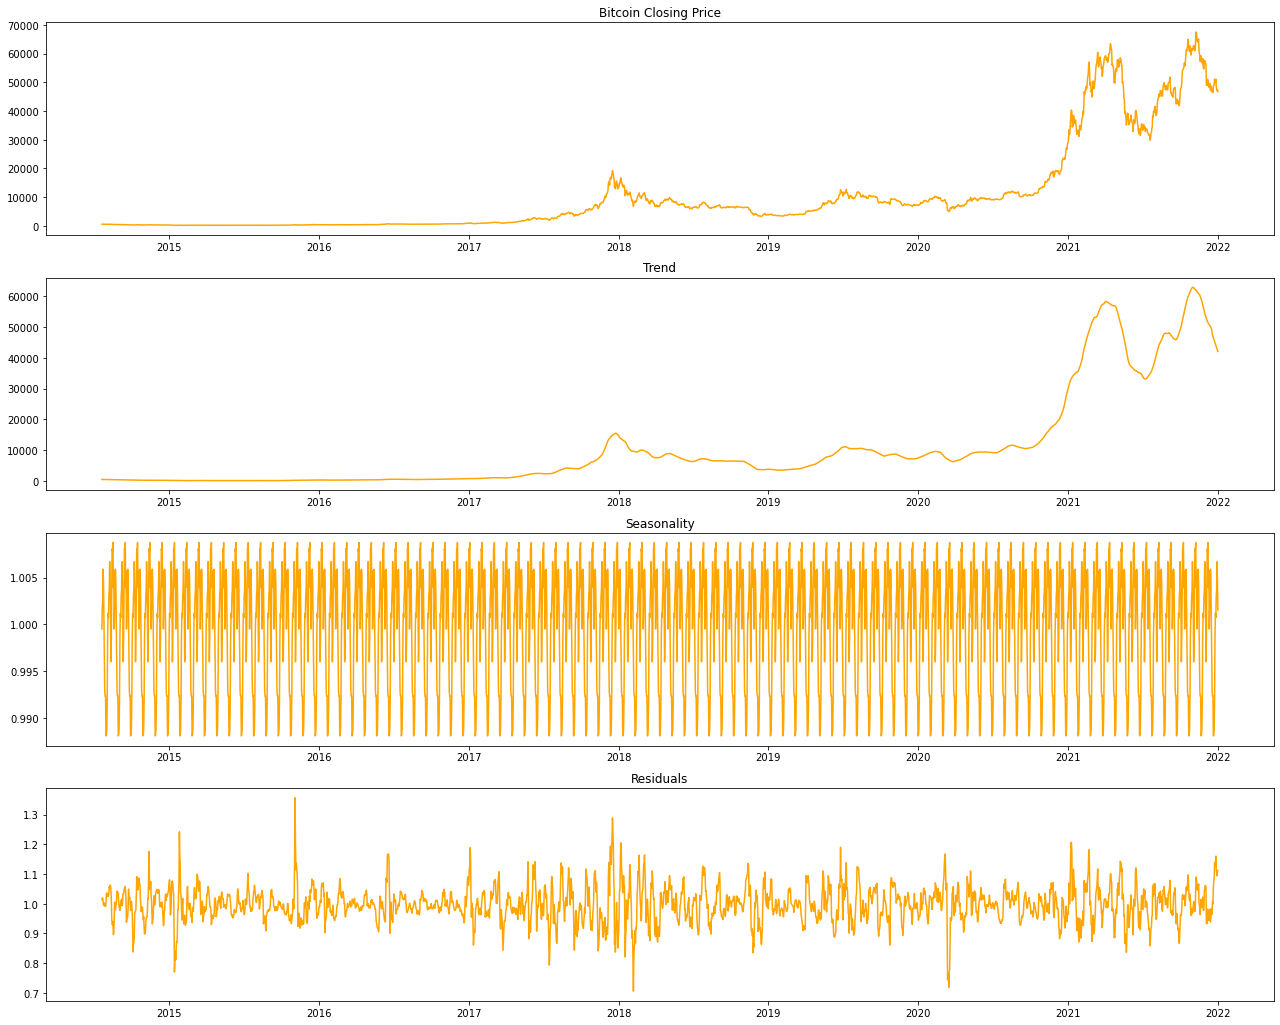

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_result_mult = seasonal_decompose(bitcoin_df['Close'], model="multiplicative", period=30, extrapolate_trend='freq')

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

fig = plt.figure(figsize = (22,18))

plt.subplot(4, 1, 1)
plt.title('Bitcoin Closing Price')
plt.plot(bitcoin_df.index, bitcoin_df['Close'], c = 'orange')

plt.subplot(4, 1, 2)
plt.title('Trend')
plt.plot(trend, c = 'orange')

plt.subplot(4, 1, 3)
plt.title('Seasonality')
plt.plot(seasonal, c = 'orange')

plt.subplot(4, 1, 4)
plt.title('Residuals')
plt.plot(residual, c = 'orange')



plt.show()

While there does seem to be some kind of consistent seasonality in the `Seasonality` graph, the seasonality only varies by 0.005%, meaning no large affect was found, and the `Residuals` graph tells a similar story. The residuals are heteroscedastically distributed, meaning there is a lot of variance. Specifically, there is a lot of variance in 2017, when the largest period of price increase in our dataset occured.<br><br>


Next I will try with a yearly seasonality.

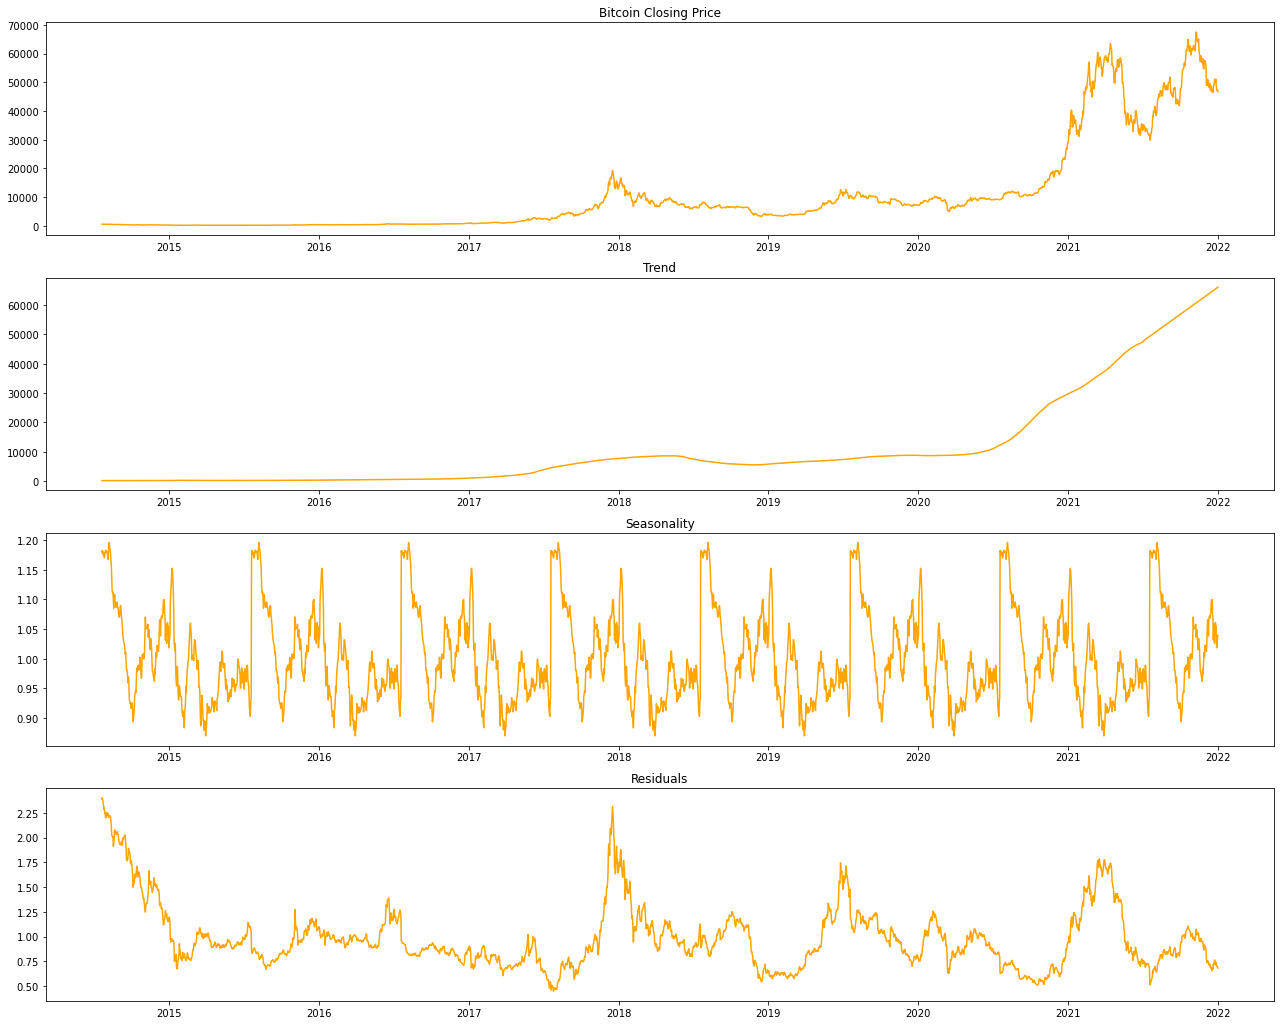

In [24]:
decompose_result_mult = seasonal_decompose(bitcoin_df['Close'], model="multiplicative", period=365, extrapolate_trend='freq')

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

fig = plt.figure(figsize = (22,18))

plt.subplot(4, 1, 1)
plt.title('Bitcoin Closing Price')
plt.plot(bitcoin_df.index, bitcoin_df['Close'], c = 'orange')

plt.subplot(4, 1, 2)
plt.title('Trend')
plt.plot(trend, c = 'orange')

plt.subplot(4, 1, 3)
plt.title('Seasonality')
plt.plot(seasonal, c = 'orange')

plt.subplot(4, 1, 4)
plt.title('Residuals')
plt.plot(residual, c = 'orange')



plt.show()

This approach seems to have given slightly better results as the seasonality now ranges by up to 20% compared to 0.005% for monthly. However, the residuls still have far too much variance for us to have properly defined Bitcoins seasonality.

Bitcoin however does have its own unique seasonality in its halving events. These are generally considered cycles for bitcoin as they are defined periods of length where a certain block reward is being issued. The block reward is the only way new coins enter the circulating supply, and a lot of demand is created by the level of supply. A halving occurs every 1,458 days as previously mentioned, so lets decompose the dataset with the period set to 1,458 days.

__One important thing to note__: in order for our period to be 1,458 days, we must have a total of 2916 observations, as `seasonal_decompose` requires at least two cycles worth of observations. For just this analysis of seasonality, I will import the 1 Day Historical Price Data aquired in the `Aquiring and Cleaning Historical Price Data for Cryptocurrencies` notebook.

In [25]:
bitcoin_1day_df = pd.read_csv("./data/BTCUSD_1D Historical Data.csv")
bitcoin_1day_df.rename(columns = {'Unnamed: 0': 'Date'}, inplace = True)
bitcoin_1day_df.set_index('Date', inplace = True)
bitcoin_1day_df.head()

Open       Close        High         Low     Volume
Date                                                                 
2013-04-15   93.343552   93.196398   93.779854   92.732950  70.253082
2013-04-16   66.376708   66.283507   67.081630   65.280107  92.148519
2013-04-17   82.747298   82.802263   83.302151   82.256810  77.669528
2013-04-18   94.566261   94.611351   94.887578   94.308964  33.380671
2013-04-19  118.794566  118.832455  119.566758  117.988299  80.617867

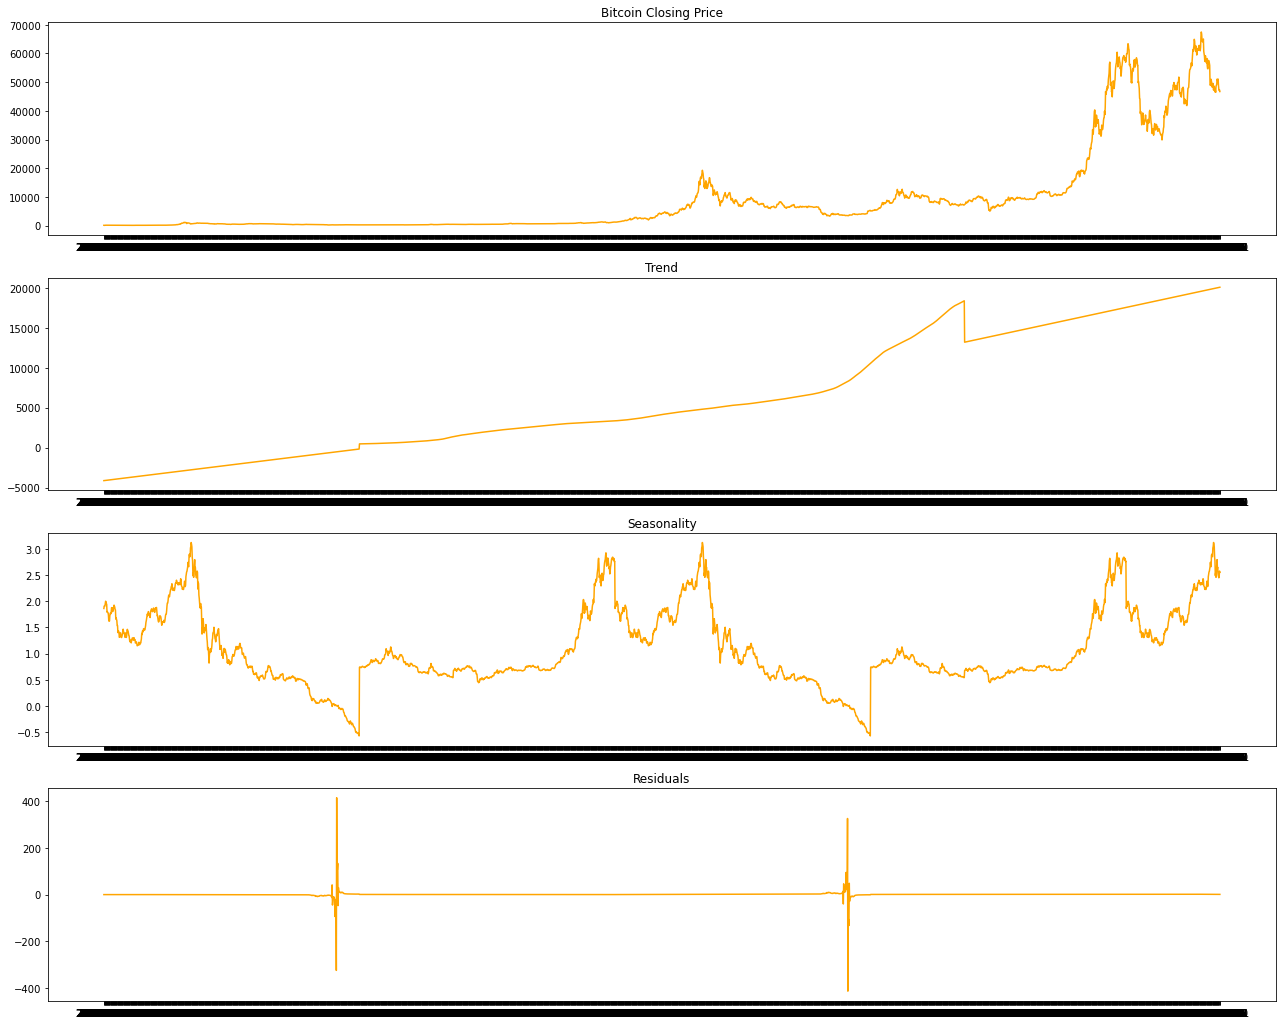

In [26]:
# this cell might take a minute to run

decompose_result_mult = seasonal_decompose(bitcoin_1day_df['Close'], model="multiplicative", period=1458, extrapolate_trend='freq')

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

fig = plt.figure(figsize = (22,18))

plt.subplot(4, 1, 1)
plt.title('Bitcoin Closing Price')
plt.plot(bitcoin_1day_df.index, bitcoin_1day_df['Close'], c = 'orange')

plt.subplot(4, 1, 2)
plt.title('Trend')
plt.plot(trend, c = 'orange')

plt.subplot(4, 1, 3)
plt.title('Seasonality')
plt.plot(seasonal, c = 'orange')

plt.subplot(4, 1, 4)
plt.title('Residuals')
plt.plot(residual, c = 'orange')



plt.show()

Unfortunately this also gives poor results as the residuals range far too high. So far it seems that there is no clear seasonality for Bitcoins price, as the residuals are not stationary. The next approach I will take is Multi Seasonal Time Series Decomposition, where I try get the residuals to become stationary by trying to identity multiple seasonalities.

### Multi-Seasonal Decomposition <a class="anchor" id="multi_decomp" ></a>

I will start from the yearly seasonality from above, and move downward in timeframes from Quarterly, Monthly to Weekly. To save space in this notebook, I have tried out all of the combinations and choosen the decomposition that returns the most stationary residuals. In this case, accounting for yearly, quarterly and monthly have given the best results.

In [27]:
# this cell will take a few minutes to run

decompose_result_365 = seasonal_decompose(bitcoin_df['Close'], model="multiplicative", period=365, extrapolate_trend='freq')

decompose_result_91 = seasonal_decompose(bitcoin_df['Close'] - np.array(decompose_result_365.seasonal), model="multiplicative", period=91, extrapolate_trend='freq')

decompose_result_30 = seasonal_decompose(bitcoin_df['Close'] - np.array(decompose_result_91.seasonal), model="multiplicative", period=30, extrapolate_trend='freq')


seasonal_365 = decompose_result_365.seasonal

seasonal_91 = decompose_result_91.seasonal

seasonal_30 = decompose_result_30.seasonal


trend = decompose_result_30.trend

residuals = decompose_result_30.resid


Now I'll run the seasonal_decompose with yearly seasonality and the log transformed data. Now that the graph looks more linear, I will set the model to additive.

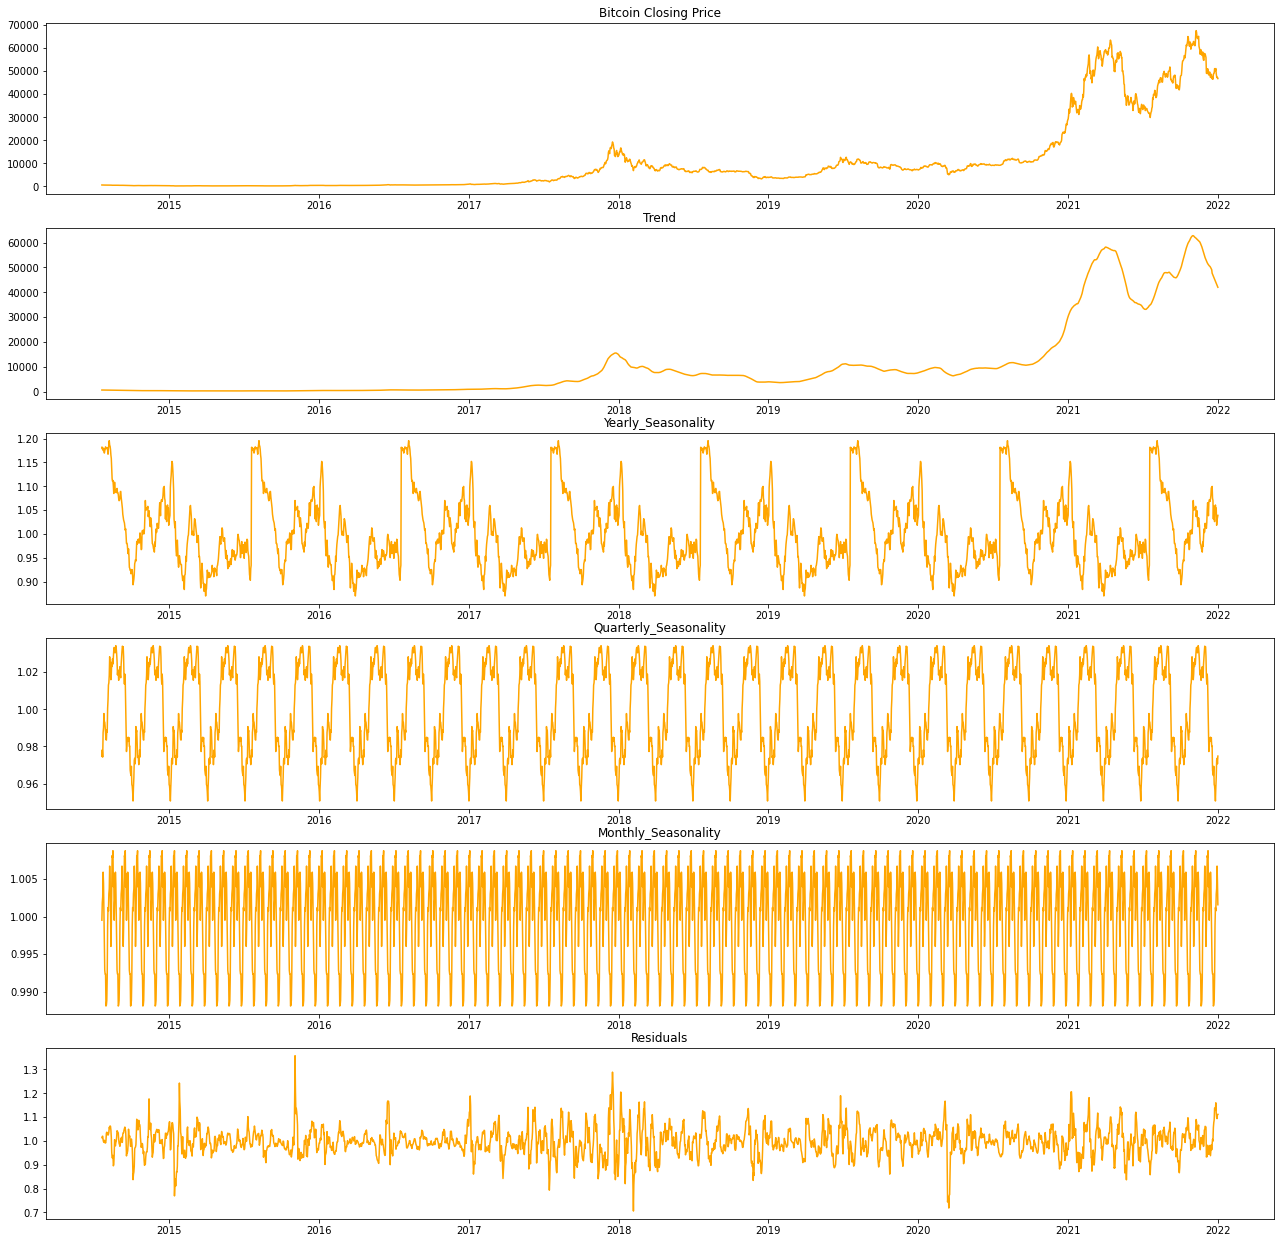

In [28]:
fig = plt.figure(figsize = (22,22))

plt.subplot(6, 1, 1)
plt.title('Bitcoin Closing Price')
plt.plot(bitcoin_df.index, bitcoin_df['Close'], c = 'orange')

plt.subplot(6, 1, 2)
plt.title('Trend')
plt.plot(trend, c = 'orange')

plt.subplot(6, 1, 3)
plt.title('Yearly_Seasonality')
plt.plot(seasonal_365, c = 'orange')

plt.subplot(6, 1, 4)
plt.title('Quarterly_Seasonality')
plt.plot(seasonal_91, c = 'orange')

plt.subplot(6, 1, 5)
plt.title('Monthly_Seasonality')
plt.plot(seasonal_30, c = 'orange')

plt.subplot(6, 1, 6)
plt.title('Residuals')
plt.plot(residuals, c = 'orange')



plt.show()

The residuals look much better now, but examining the residuals I can observe another seasonality. There is a spike in 2015, then again in 2018 and another in 2021. This could be indicating a 3 year seasonality. I will add this component and run the above code again below. The period will be 3 x 365 = 1095.

In [29]:
decompose_result_1095 = seasonal_decompose(bitcoin_df['Close'], model="multiplicative", period=1095, extrapolate_trend='freq')

decompose_result_365 = seasonal_decompose(bitcoin_df['Close'] - np.array(decompose_result_1095.seasonal), model="multiplicative", period=365, extrapolate_trend='freq')

decompose_result_91 = seasonal_decompose(bitcoin_df['Close'] - np.array(decompose_result_365.seasonal), model="multiplicative", period=91, extrapolate_trend='freq')

decompose_result_30 = seasonal_decompose(bitcoin_df['Close'] - np.array(decompose_result_91.seasonal), model="multiplicative", period=30, extrapolate_trend='freq')

seasonal_1095 = decompose_result_1095.seasonal

seasonal_365 = decompose_result_365.seasonal

seasonal_91 = decompose_result_91.seasonal

seasonal_30 = decompose_result_30.seasonal


trend = decompose_result_30.trend

residuals = decompose_result_30.resid

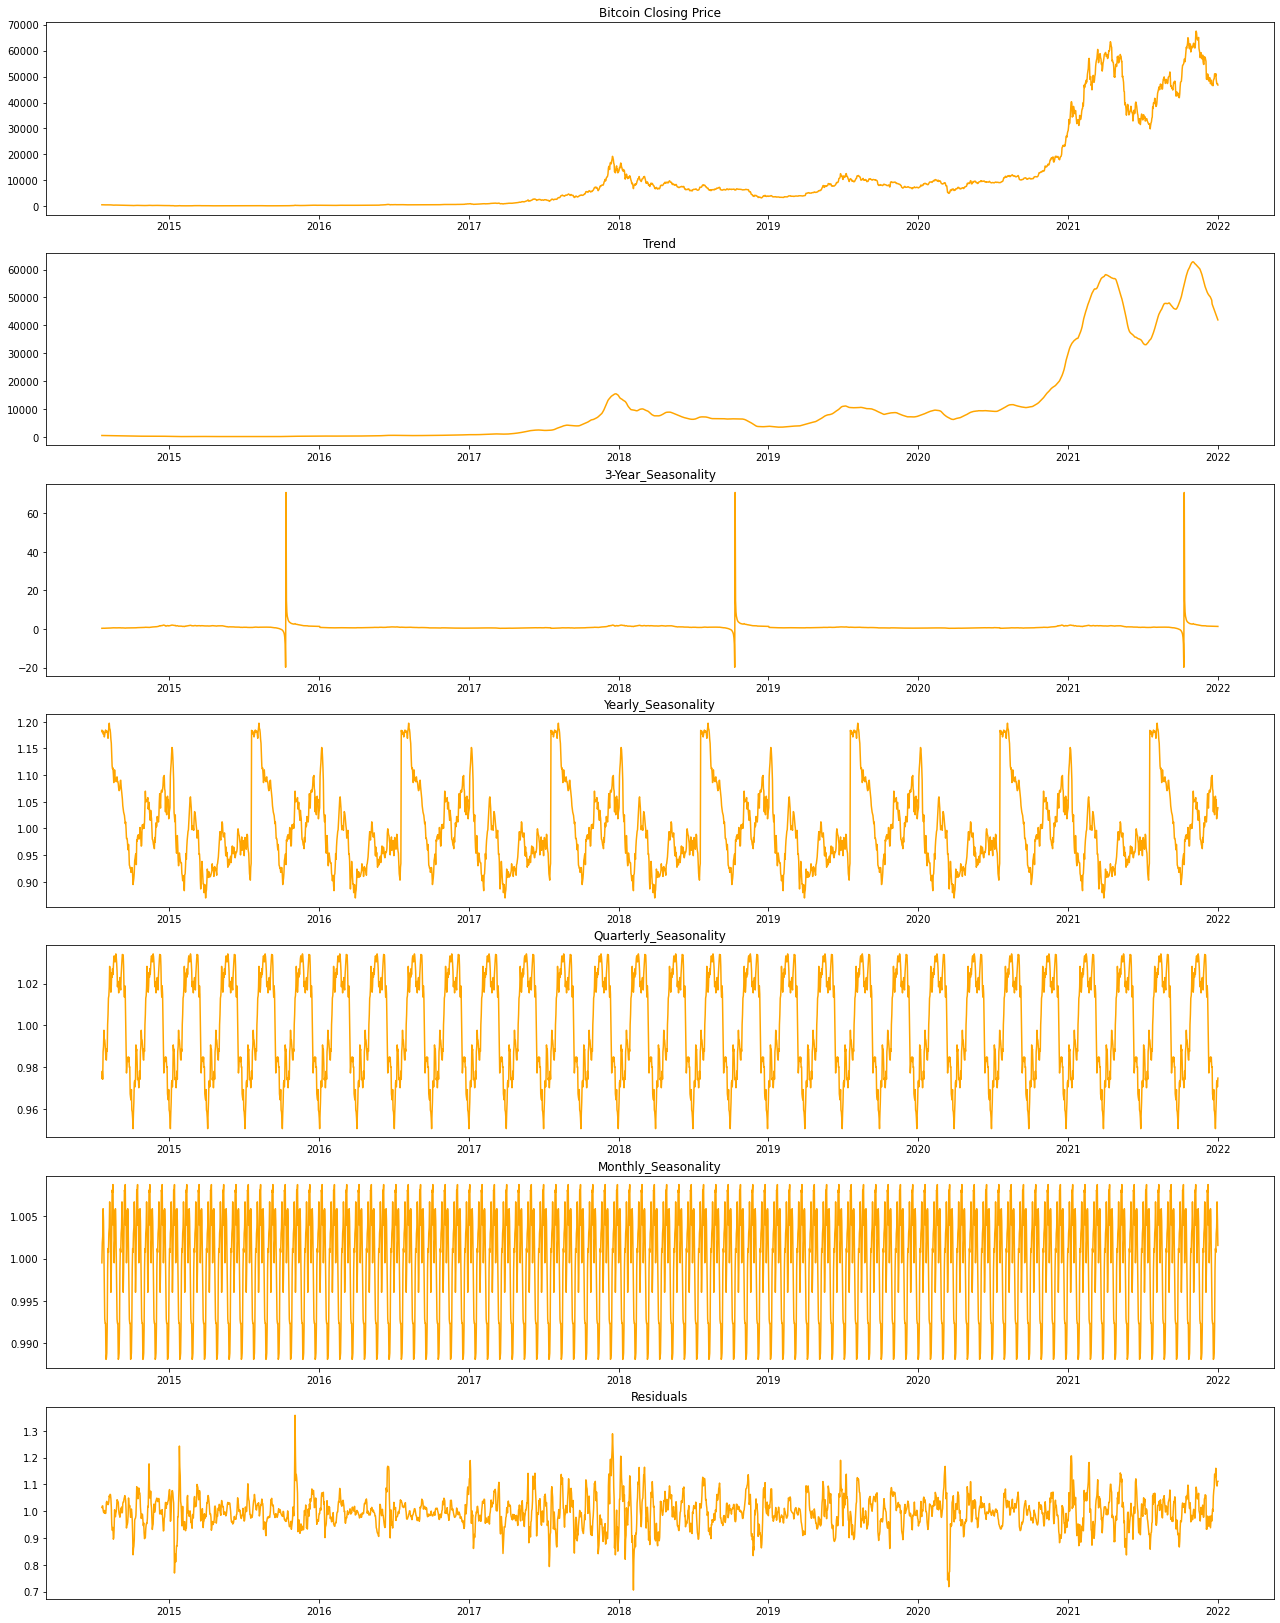

In [33]:
fig = plt.figure(figsize = (22,29))

plt.subplot(7, 1, 1)
plt.title('Bitcoin Closing Price')
plt.plot(bitcoin_df.index, bitcoin_df['Close'], c = 'orange')

plt.subplot(7, 1, 2)
plt.title('Trend')
plt.plot(trend, c = 'orange')

plt.subplot(7, 1, 3)
plt.title('3-Year_Seasonality')
plt.plot(seasonal_1095, c = 'orange')

plt.subplot(7, 1, 4)
plt.title('Yearly_Seasonality')
plt.plot(seasonal_365, c = 'orange')

plt.subplot(7, 1, 5)
plt.title('Quarterly_Seasonality')
plt.plot(seasonal_91, c = 'orange')

plt.subplot(7, 1, 6)
plt.title('Monthly_Seasonality')
plt.plot(seasonal_30, c = 'orange')

plt.subplot(7, 1, 7)
plt.title('Residuals')
plt.plot(residuals, c = 'orange')



plt.show()

It does not appear to have made a difference as the 3-year seasonality detected (as seen in the graph) does not line up with the peaks previously described. This means that ultimately the price of Bitcoin does not have a stationary trend. However, this is to be expected. If the price of Bitcoin was easily predictable, then many traders would be been making money on that information. This leads to a paradox where if all traders knew how to make money in the same way, then that way would stop functioning. Stocks and cryptocurrenies are traded so that there is always a seller and a buyer, but if everyone knew to buy at a certain moment, then no one would be selling for others to buy. That would then lead to unexpected price movement, invalidating the theory all these traders were trading on.<br><br> To summarize, there seems to be some seasonality in the form of year, quarterly and monthly, but the residuals are heteroscedastically distributed, indicating a change in variance over time. This leads the time seris to be considered non-stationary.

## Conclusion <a class="anchor" id="conclusion" ></a>

This brings me to the end of the EDA for this Bitcoin Dataset where I explored important metrics related to the Cryptocurrency Market such as:
* EMA's 
* The Fear and Greed Index
* The Puell Multiple
* Stock-to-Flow Model
* Key Dates in Bitcoins History<br><br>

as well as performed seasonal and multi-seasonal decomposition. The results of the decomposition showed that the underlying timeseries is not stationary and might not be decomposable. 